/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


   EDUCATION SOUTH     SEX  EXPERIENCE       UNION  WAGE  AGE      RACE  \
0          8    no  female          21  not_member  5.10   35  Hispanic   
1          9    no  female          42  not_member  4.95   57     White   
2         12    no    male           1  not_member  6.67   19     White   
3         12    no    male           4  not_member  4.00   22     White   
4         12    no    male          17  not_member  7.50   35     White   

  OCCUPATION         SECTOR       MARR  
0      Other  Manufacturing    Married  
1      Other  Manufacturing    Married  
2      Other  Manufacturing  Unmarried  
3      Other          Other  Unmarried  
4      Other          Other    Married  
Index(['EDUCATION', 'SOUTH', 'SEX', 'EXPERIENCE', 'UNION', 'WAGE', 'AGE',
       'RACE', 'OCCUPATION', 'SECTOR', 'MARR'],
      dtype='object')
Ridge Regression MSE: 22.324511499518042
LASSO Regression MSE: 32.94700199282025


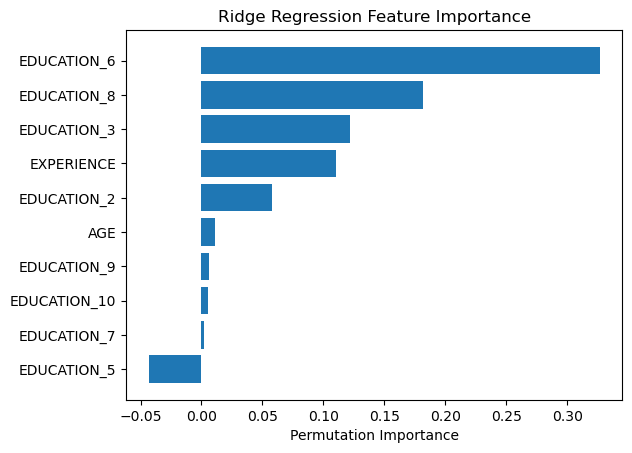

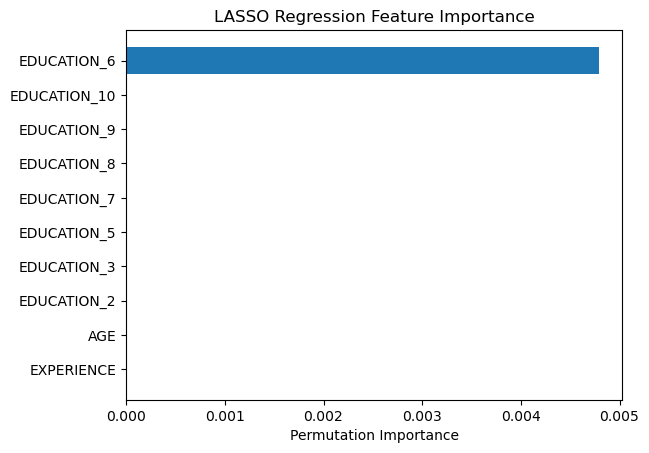


Conclusion and Learning
Ridge Regression MSE: 22.324511499518042
LASSO Regression MSE: 32.94700199282025

Permutation Importance Analysis:
Ridge Regression Important Features:
EDUCATION_2: 0.05760933119687726
EXPERIENCE: 0.11029120797227568
EDUCATION_3: 0.12206358978174625
EDUCATION_8: 0.18189406980035408
EDUCATION_6: 0.32656941824162145

LASSO Regression Important Features:
EDUCATION_7: 0.0
EDUCATION_8: 0.0
EDUCATION_9: 0.0
EDUCATION_10: 0.0
EDUCATION_6: 0.004787685633100125


In [12]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the dataset
wages = fetch_openml(data_id=534, as_frame=True)
df = wages.frame

# Display the first few rows and column names to identify the correct target column name
print(df.head())
print(df.columns)

# Define the correct target column name
target = 'WAGE'

# Preprocess the data
categorical_features = ['EDUCATION', 'SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
numerical_features = ['EXPERIENCE', 'AGE']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Define the pipeline with a Ridge regressor
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define the pipeline with a Lasso regressor
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Transform the target variable using a logarithm
log_ridge = TransformedTargetRegressor(regressor=ridge_pipeline, func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(regressor=lasso_pipeline, func=np.log, inverse_func=np.exp)

# Define the grid search parameters
param_grid = {
    'regressor__regressor__alpha': [0.1, 1.0, 10.0]
}

ridge_grid_search = GridSearchCV(log_ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search = GridSearchCV(log_lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the models
ridge_grid_search.fit(X_train, y_train)
lasso_grid_search.fit(X_train, y_train)

# Evaluate the models
ridge_best_model = ridge_grid_search.best_estimator_
lasso_best_model = lasso_grid_search.best_estimator_

y_pred_ridge = ridge_best_model.predict(X_test)
y_pred_lasso = lasso_best_model.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)

print("Ridge Regression MSE:", ridge_mse)
print("LASSO Regression MSE:", lasso_mse)

# Permutation Importance
ridge_importance = permutation_importance(ridge_best_model, X_test, y_test, n_repeats=10, random_state=42)
lasso_importance = permutation_importance(lasso_best_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature names after one-hot encoding
def get_feature_names(preprocessor):
    """Get feature names from a ColumnTransformer."""
    output_features = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(features)
        elif name == 'cat':
            output_features.extend(transformer.get_feature_names_out(features))
    return output_features

# Fit preprocessor to get the correct feature names
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor)

def plot_importance(importance, feature_names, title):
    sorted_idx = importance.importances_mean.argsort()
    plt.barh(np.array(feature_names)[sorted_idx], importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(title)
    plt.show()

plot_importance(ridge_importance, feature_names, "Ridge Regression Feature Importance")
plot_importance(lasso_importance, feature_names, "LASSO Regression Feature Importance")

# Conclusion
print("\nConclusion and Learning")
print("=======================")
print(f"Ridge Regression MSE: {ridge_mse}")
print(f"LASSO Regression MSE: {lasso_mse}")

print("\nPermutation Importance Analysis:")
print("Ridge Regression Important Features:")
for i in np.argsort(ridge_importance.importances_mean)[-5:]:
    print(f"{feature_names[i]}: {ridge_importance.importances_mean[i]}")

print("\nLASSO Regression Important Features:")
for i in np.argsort(lasso_importance.importances_mean)[-5:]:
    print(f"{feature_names[i]}: {lasso_importance.importances_mean[i]}")